In [1]:
import os, os.path
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.special import sph_harm
import weave
from weave import converters
from numba import jit, vectorize
import numexpr
%load_ext Cython

In [3]:
from colloids import boo, particles

In [4]:
path = '/data/mleocmach/Documents/Tsurusawa/0_Data_retracked/3_DenseGel/163A/2_ageing/'
pos = np.loadtxt(os.path.join(path, '163A_1415_ageing_t000.dat'), skiprows=2)
bonds = np.loadtxt(os.path.join(path, '163A_1415_ageing_t000.bonds'), dtype=int)
inside = np.min((pos-pos.min(0)>14) & (pos.max()-pos>14), -1)
ngbs = particles.bonds2ngbs(bonds, len(pos))

In [13]:
%timeit boo.weave_qlm(pos, ngbs, inside)

1 loop, best of 3: 305 ms per loop


In [4]:
%timeit boo.bonds2qlm(pos, bonds)

1 loops, best of 3: 517 ms per loop


In [22]:
import math
def python_qlm(pos, ngbs, inside, l=6):
    qlm = np.zeros([len(pos), l+1], np.complex128)
    cart = np.zeros(3)
    sph = np.zeros(3)
    for i in range(ngbs.shape[0]):
        if not inside[i]:
            continue
        nb = 0
        for j in range(ngbs.shape[1]):
            q = ngbs[i,j]
            if q < 0 or q >= len(pos):
                continue
            nb += 1
            cart[:] = pos[i] - pos[q]
            sph[0] = cart[0]*cart[0] + cart[1]*cart[1] + cart[2]*cart[2]
            if cart[2]**2 == sph[0] or sph[0]+1.0 == 1.0:
                sph[1:] = 0
            else:
                sph[0] = math.sqrt(sph[0])
                sph[1] = math.acos(cart[2]/sph[0])
                sph[2] = math.atan2(cart[1], cart[0])
                if sph[2] < 0:
                    sph[2] += 2.0*math.pi
            qlm[i] += sph_harm(
                np.arange(l+1), l, 
                sph[2], 
                sph[1]
                )
        if nb>0:
            qlm[i] /= nb
    return qlm

In [23]:
%timeit python_qlm(pos, ngbs, inside)

1 loop, best of 3: 4.28 s per loop


In [4]:
%%cython --annotate
import numpy as np
from scipy.special.cython_special cimport sph_harm
cimport numpy as np
from libc.math cimport sqrt, acos, atan2, M_PI
cimport cython

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_qlm(
    np.ndarray[np.float64_t, ndim=2] pos, 
    np.ndarray[np.int64_t, ndim=2] ngbs, 
    np.ndarray[np.uint8_t, ndim=1, cast=True] inside, 
    int l=6
):
    cdef int i,j, q, nb, m, d
    cdef double r, r2, theta, phi, z
    cdef long Npos = pos.shape[0]
    cdef long Nngb = ngbs.shape[1]
    cdef np.ndarray[dtype=np.complex128_t, ndim=2] qlm = np.zeros([len(pos), l+1], np.complex128)
    #cdef np.ndarray[dtype=double, ndim=1] cart = np.zeros(3, float)
    cdef double[3] cart
    for i in range(Npos):
        if not inside[i]:
            continue
        nb = 0
        for j in range(Nngb):
            q = ngbs[i,j]
            if q < 0 or q >= Npos:
                continue
            nb += 1
            for d in range(3):
                cart[d] = pos[i,d] - pos[q,d]
            r2 = cart[0]**2 + cart[1]**2 + cart[2]**2
            if cart[2]**2 == r2 or r2+1.0 == 1.0:
                theta = 0
                phi = 0
            else:
                r = sqrt(r2)
                z = cart[2]
                phi = acos(z/r)
                theta = atan2(cart[1], cart[0])
                if theta < 0:
                    theta += 2.0*M_PI
            for m in range(l+1):
                qlm[i,m] = qlm[i,m] + sph_harm(m, l, theta, phi)
        if nb>0:
            for m in range(l+1):
                qlm[i,m] = qlm[i,m] / nb
    return qlm

In [6]:
%timeit cython_qlm(pos, ngbs, inside)

1 loops, best of 3: 540 ms per loop


In [94]:
sph_harm?

In [134]:
qlm_w = boo.weave_qlm(pos, ngbs, inside)

In [201]:
qlm_c = cython_qlm(pos, ngbs, inside)

In [202]:
np.mean(np.abs(qlm_w - qlm_c)<1e-16)

0.81391235399957307

In [187]:
qlm_w[0]

array([ 0.04028486+0.j        ,  0.05799787+0.06639547j,
        0.04605032-0.09580622j, -0.05903408-0.0054351j ,
        0.13045725-0.20548051j, -0.18253487-0.07674777j,
        0.09087308+0.00445716j])

In [188]:
qlm_c[0]

array([ 0.04028486+0.j        ,  0.05799787+0.06639547j,
        0.04605032-0.09580622j, -0.05903408-0.0054351j ,
        0.13045725-0.20548051j, -0.18253487-0.07674777j,
        0.09087308+0.00445716j])

In [183]:
sph_harm(0, 6, 3.685749891321086, 1.4481876153314692)

(-0.22243770324198525+0j)

In [182]:
sph_harm?

## $w_\ell$

$$ w_\ell = \sum_{m_1+m_2+m_3=0} 
			\left( \begin{array}{ccc}
				\ell & \ell & \ell \\
				m_1 & m_2 & m_3 
			\end{array} \right)
			q_{\ell m_1} q_{\ell m_2} q_{\ell m_3}
			$$

In [5]:
qlm = boo.bonds2qlm(pos, bonds)

In [9]:
%timeit boo.wl(qlm)

1 loops, best of 3: 482 ms per loop


In [21]:
from colloids.boo import get_qlm, get_w3j
def python_wl(qlm):
    l = qlm.shape[1]-1
    w = np.zeros(qlm.shape[0], qlm.dtype)
    for m1 in range(-l, l+1):
        for m2 in range(-l, l+1):
            m3 = -m1-m2
            if -l<=m3 and m3<=l:
                w+= get_w3j(l, [m1, m2, m3]) * get_qlm(qlm, m1) * get_qlm(qlm, m2) * get_qlm(qlm, m3)
    return w.real

In [31]:
%timeit python_wl(qlm)

10 loops, best of 3: 113 ms per loop


In [18]:
np.sum(boo.wl(qlm) - python_wl(qlm).real > 1e-12)

0

In [118]:
@jit
def numba_wl(qlm):
    l = qlm.shape[1]-1
    w = np.zeros(qlm.shape[0], qlm.dtype)
    for m1 in range(-l, l+1):
        for m2 in range(-l, l+1):
            m3 = -m1-m2
            if -l<=m3 and m3<=l:
                w+= get_w3j(l, [m1, m2, m3]) * get_qlm(qlm, m1) * get_qlm(qlm, m2) * get_qlm(qlm, m3)
    return w.real

((1000000, 3), (1000000, 3))

In [119]:
%timeit numba_wl(qlm)

100 loops, best of 3: 16.3 ms per loop


In [13]:
[len(it) for it in _w3j]

[1, 4, 9, 16, 25, 36]

In [14]:
w3j = np.zeros([6,36])
w3j[0,0] = 1
w3j[1,:4] = np.sqrt([2/35., 1/70., 2/35., 3/35.])*[-1,1,1,-1]
w3j[2,:9] = np.sqrt([
        2/1001., 1/2002., 11/182., 5/1001.,
        7/286., 5/143., 14/143., 35/143., 5/143.,
        ])*[3, -3, -1/3.0, 2, 1, -1/3.0, 1/3.0, -1/3.0, 1]
w3j[3,:16] = np.sqrt([
        1/46189., 1/46189.,
        11/4199., 105/46189.,
        1/46189., 21/92378.,
        1/46189., 35/46189., 14/46189.,
        11/4199., 21/4199., 7/4199.,
        11/4199., 77/8398., 70/4199., 21/4199.
        ])*[-20, 10, 1, -2, -43/2.0, 3, 4, 2.5, -6, 2.5, -1.5, 1, 1, -1, 1, -2]
w3j[4,:25] = np.sqrt([
        10/96577., 5/193154.,
        1/965770., 14/96577.,
        1/965770., 66/482885.,
        5/193154., 3/96577., 77/482885.,
        65/14858., 5/7429., 42/37145.,
        65/14858., 0.0, 3/7429., 66/37145.,
        13/74290., 78/7429., 26/37145., 33/37145.,
        26/37145., 13/37145., 273/37145., 429/37145., 11/7429.,
        ])*[
            7, -7, -37, 6, 73, -3,
            -5, -8, 6, -1, 3, -1,
            1, 0, -3, 2, 7, -1, 3, -1,
            1, -3, 1, -1, 3]
w3j[5,:36] = np.sqrt([
        7/33393355., 7/33393355.,
        7/33393355., 462/6678671.,
        7/33393355., 1001/6678671.,
        1/233753485., 77/6678671., 6006/6678671.,
        1/233753485., 55/46750697., 1155/13357342.,
        1/233753485., 2926/1757545., 33/46750697., 3003/6678671.,
        119/1964315., 22/2750041., 1914/474145., 429/5500082.,
        17/13750205., 561/2750041., 77/392863., 143/27500410., 2002/392863.,
        323/723695., 1309/20677., 374/144739., 143/144739., 1001/206770.,
        323/723695., 7106/723695., 561/723695., 2431/723695., 2002/103385., 1001/103385.
        ])*[
            -126, 63, 196/3.0, -7, -259/2.0, 7/3.0,
            1097/3.0, 59/6.0, -2,
            4021/6.0, -113/2.0, 3,
            -914, 1/3.0, 48, -3,
            -7/3.0, 65/3.0, -1, 3,
            214/3.0, -3, -2/3.0, 71/3.0, -1,
            3, -1/3.0, 5/3.0, -2, 1/3.0,
            2/3.0, -1/3.0, 2, -4/3.0, 2/3.0, -1]

In [11]:
_w3j_m1_offset = np.array([0,1,2,4,6,9,12,16,20,25,30], int)

In [21]:
@jit(['float64(int64, int64[:])'], nopython=True)
def get_w3j(l, ms):
    sm = np.sort(np.abs(ms))
    return w3j[l/2, _w3j_m1_offset[sm[-1]] + sm[0]]

@jit(['complex128(complex128[:], int64)'], nopython=True)
def get_qlm(qlm, m):
    if m>=0:
        return qlm[m]
    if (-m)%2 == 0:
        return qlm[-m].conjugate()
    return -qlm[-m].conjugate()

@jit(['float64(complex128[:])'], nopython=True)
def wl(qlm):
    """Third order rotational invariant of the bond orientational order of l-fold symmetry
    $$ w_\ell = \sum_{m_1+m_2+m_3=0} 
			\left( \begin{array}{ccc}
				\ell & \ell & \ell \\
				m_1 & m_2 & m_3 
			\end{array} \right)
			q_{\ell m_1} q_{\ell m_2} q_{\ell m_3}
			$$"""
    l = qlm.shape[0]-1
    w = 0.0
    for m1 in range(-l, l+1):
        for m2 in range(-l, l+1):
            m3 = -m1-m2
            if -l<=m3 and m3<=l:
                w+= (get_w3j(l, np.array([m1, m2, m3])) * get_qlm(qlm, m1) * get_qlm(qlm, m2) * get_qlm(qlm, m3)).real
    return w

## BOO product

In [22]:
def boo_product(qlm1, qlm2):
    """Product between two qlm"""
    n = np.atleast_2d(numexpr.evaluate(
        """real(complex(real(a), -imag(a)) * b)""",
        {'a':qlm1, 'b':qlm2}
        ))
    p = numexpr.evaluate(
        """4*pi/(2*l+1)*(2*na + nb)""",
        {
            'na': n[:,1:].sum(-1),
            'nb': n[:,0],
            'l': n.shape[1]-1,
            'pi': np.pi
            })
    return p

In [23]:
boo_product(qlm[0], qlm[1])

array([-0.09042815])

In [26]:
%timeit boo_product(qlm[0], qlm[1])

The slowest run took 4.43 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 71.1 µs per loop


In [27]:
%timeit boo_product(qlm[:1000], qlm[-1000:])

1000 loops, best of 3: 256 µs per loop


In [30]:
def numpy_boo_product(qlm1, qlm2):
    """Product between two qlm"""
    n = np.atleast_2d((qlm1 * np.conj(qlm2)).real)
    l = n.shape[1]-1
    return 4*np.pi/(2*l+1)*(2*n[:,1:].sum(-1) + n[:,0])

In [31]:
numpy_boo_product(qlm[0], qlm[1])

array([-0.09042815])

In [32]:
%timeit numpy_boo_product(qlm[0], qlm[1])

The slowest run took 7.79 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 20.3 µs per loop


In [33]:
%timeit numpy_boo_product(qlm[:1000], qlm[-1000:])

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 94.2 µs per loop


In [44]:
@jit([
    "float64[:](complex128[:,:], complex128[:,:])", 
    "float64[:](complex128[:], complex128[:])",
    "float64[:](complex128[:], complex128[:,:])",
    "float64[:](complex128[:,:], complex128[:])"
    ], nopython=True)
def numba_boo_product(qlm1, qlm2):
    """Product between two qlm"""
    n = np.atleast_2d((qlm1 * np.conj(qlm2)).real)
    l = n.shape[1]-1
    return 4*np.pi/(2*l+1)*(2*n[:,1:].sum(-1) + n[:,0])

In [45]:
numba_boo_product(qlm[0], qlm[1])

array([-0.09042815])

In [46]:
%timeit numba_boo_product(qlm[0], qlm[1])

The slowest run took 12.21 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 3.36 µs per loop


In [47]:
%timeit numba_boo_product(qlm[:1000], qlm[-1000:])

10000 loops, best of 3: 59.3 µs per loop


In [48]:
%timeit numba_boo_product(qlm[0], qlm[-1000:])

10000 loops, best of 3: 52.6 µs per loop


In [49]:
%timeit numba_boo_product(qlm[:1000], qlm[-1])

10000 loops, best of 3: 47.4 µs per loop


In [96]:
from numba import guvectorize
@guvectorize(['void(complex128[:], complex128[:], float64[:])'], '(n),(n)->()', nopython=True)
def numba2_boo_product(qlm1, qlm2, prod):
    """Product between two qlm"""
    l = qlm1.shape[0]-1
    prod[0] = (qlm1[0] * qlm2[0].conjugate()).real
    for i in range(1, len(qlm1)):
        prod[0] += 2 * (qlm1[i] * qlm2[i].conjugate()).real
    prod[0] *= 4*np.pi/(2*l+1)

In [97]:
numba2_boo_product(qlm[0], qlm[1])

-0.090428150978496991

In [98]:
%timeit numba2_boo_product(qlm[0], qlm[1])

The slowest run took 25.59 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.11 µs per loop


In [102]:
%timeit numba2_boo_product(qlm[:1000], qlm[-1000:])

The slowest run took 5.40 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 20.9 µs per loop


In [101]:
%timeit numba2_boo_product(qlm[0], qlm[-1000:])

The slowest run took 4.68 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 19.4 µs per loop


In [100]:
%timeit numba2_boo_product(qlm[:1000], qlm[-1])

The slowest run took 5.23 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 19.2 µs per loop


## Spatial correlation

In [6]:
def coarsegrain_qlm(qlm, bonds, inside):
    """Coarse grain the bond orientational order on the neighbourhood of a particle
    $$Q_{\ell m}(i) = \frac{1}{N_i+1}\left( q_{\ell m}(i) +  \sum_{j=0}^{N_i} q_{\ell m}(j)\right)$$
    Returns Qlm and the mask of the valid particles
    """
    #Valid particles must be valid themselves have only valid neighbours
    inside2 = np.copy(inside)
    np.bitwise_and.at(inside2, bonds[:,0], inside[bonds[:,1]])
    np.bitwise_and.at(inside2, bonds[:,1], inside[bonds[:,0]])
    #number of neighbours
    Nngb = np.zeros(len(qlm), int)
    np.add.at(Nngb, bonds.ravel(), 1)
    #sum the boo coefficients of all the neighbours
    Qlm = np.zeros_like(qlm)
    np.add.at(Qlm, bonds[:,0], qlm[bonds[:,1]])
    np.add.at(Qlm, bonds[:,1], qlm[bonds[:,0]])
    Qlm[np.bitwise_not(inside2)] = 0
    return Qlm / np.maximum(1, Nngb)[:,None], inside2

In [7]:
Qlm, inside2 = coarsegrain_qlm(qlm, bonds, inside)

In [8]:
%timeit coarsegrain_qlm(qlm, bonds, inside)

1 loops, best of 3: 225 ms per loop


In [14]:
@jit
def numba_coarsegrain_qlm(qlm, bonds, inside):
    """Coarse grain the bond orientational order on the neighbourhood of a particle
    $$Q_{\ell m}(i) = \frac{1}{N_i+1}\left( q_{\ell m}(i) +  \sum_{j=0}^{N_i} q_{\ell m}(j)\right)$$
    Returns Qlm and the mask of the valid particles
    """
    #Valid particles must be valid themselves have only valid neighbours
    inside2 = np.copy(inside)
    np.bitwise_and.at(inside2, bonds[:,0], inside[bonds[:,1]])
    np.bitwise_and.at(inside2, bonds[:,1], inside[bonds[:,0]])
    #number of neighbours
    Nngb = np.zeros(len(qlm), int)
    np.add.at(Nngb, bonds.ravel(), 1)
    #sum the boo coefficients of all the neighbours
    Qlm = np.zeros_like(qlm)
    np.add.at(Qlm, bonds[:,0], qlm[bonds[:,1]])
    np.add.at(Qlm, bonds[:,1], qlm[bonds[:,0]])
    Qlm[np.bitwise_not(inside2)] = 0
    return Qlm / np.maximum(1, Nngb)[:,None], inside2

In [15]:
%timeit numba_coarsegrain_qlm(qlm, bonds, inside)

The slowest run took 5.83 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 228 ms per loop


In [16]:
maxdist = 30.0
bounds = np.vstack((pos[inside2].min(0)+maxdist, pos[inside2].max(0)-maxdist))
is_center = (pos>bounds[0]).min(1) & (pos<bounds[1]).min(1)

In [59]:
hq, hQ, g = boo.gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

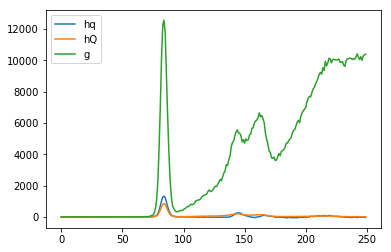

In [60]:
plt.plot(hq, label='hq')
plt.plot(hQ, label='hQ')
plt.plot(g, label='g')
plt.legend()

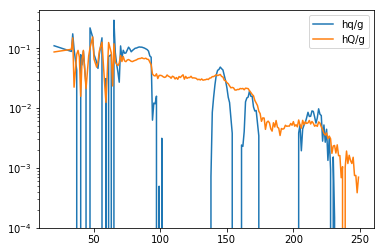

In [71]:
good = g>1
plt.plot(np.where(good)[0], hq[good]/g[good], label='hq/g')
plt.plot(np.where(good)[0], hQ[good]/g[good], label='hQ/g')
plt.yscale('log')
plt.legend()

In [255]:
%timeit boo.gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 854 ms per loop


In [66]:
maxdist = 60.0
bounds = np.vstack((pos[inside2].min(0)+maxdist, pos[inside2].max(0)-maxdist))
is_center2 = (pos>bounds[0]).min(1) & (pos<bounds[1]).min(1)

In [67]:
hq2, hQ2, g2 = boo.gG_l(pos, qlm, Qlm, is_center2, Nbins=250, maxdist=60.0)

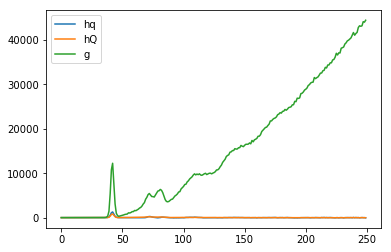

In [68]:
plt.plot(hq2, label='hq')
plt.plot(hQ2, label='hQ')
plt.plot(g2, label='g')
plt.legend()

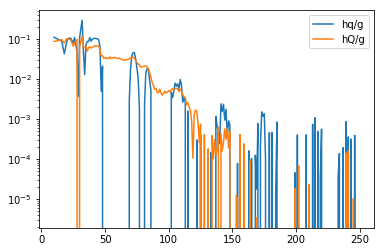

In [70]:
good = g2>1
plt.plot(np.where(good)[0], hq2[good]/g2[good], label='hq/g')
plt.plot(np.where(good)[0], hQ2[good]/g2[good], label='hQ/g')
plt.yscale('log')
plt.legend()

In [45]:
%timeit boo.gG_l(pos, qlm, Qlm, is_center2, Nbins=1000, maxdist=120.0)

1 loops, best of 3: 1.15 s per loop


In [106]:
from scipy.spatial import cKDTree as KDTree
from colloids.boo import boo_product

def gG_l(pos, qlms, Qlms, is_center, Nbins, maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    maxsq = float(maxdist**2)
    hQ = np.zeros(Nbins)
    hq = np.zeros(Nbins)
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    for i in np.where(is_center)[0]:
        js = np.array(tree.query_ball_point(pos[i], maxdist))
        js = js[js!=i]
        rs = np.sqrt(np.sum((pos[js] - pos[i])**2, -1)) / maxdist * g.shape[0]
        pqs = boo_product(qlms[i][None,:], qlms[js])
        pQs = boo_product(Qlms[i][None,:], Qlms[js])
        np.add.at(g, rs.astype(int), 1)
        np.add.at(hq, rs.astype(int), pqs)
        np.add.at(hQ, rs.astype(int), pQs)
    return hq, hQ, g

In [102]:
hq1, hQ1, g1 = gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

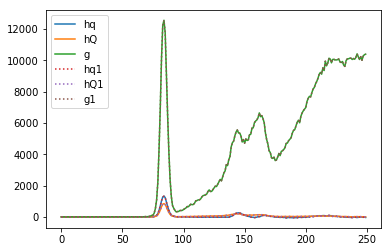

In [84]:
plt.plot(hq, label='hq')
plt.plot(hQ, label='hQ')
plt.plot(g, label='g')
plt.plot(hq1, ls=':', label='hq1')
plt.plot(hQ1, ls=':', label='hQ1')
plt.plot(g1, ls=':', label='g1')
plt.legend()

In [86]:
np.abs(g - g1).max(), np.abs(hq - hq1).max(), np.abs(hQ - hQ1).max()

(0, 1.2505552149377763e-11, 7.0485839387401938e-12)

In [96]:
%timeit gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 5.98 s per loop


In [92]:
%timeit boo.gG_l(pos, qlm, Qlm, is_center2, Nbins=1000, maxdist=120.0)

1 loops, best of 3: 19.3 s per loop


In [235]:
def gG_l_tree(pos, qlms, Qlms, is_center, Nbins, maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    rsq2r = np.sqrt(np.arange(Nbins**2)).astype(int)
    l2r = float((Nbins/maxdist)**2)
    #maxsq = float(maxdist**2)
    hQ = np.zeros(Nbins)
    hq = np.zeros(Nbins)
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    centertree = KDTree(pos[is_center], 12)
    for i, js in zip(np.where(is_center)[0], centertree.query_ball_tree(tree, maxdist)):
    #for i in np.where(is_center)[0]:
        #js = np.array(tree.query_ball_point(pos[i], maxdist))
        js = np.array(js)
        js = js[js!=i]
        #rs = np.sqrt(np.sum((pos[js] - pos[i])**2, -1)) / maxdist * g.shape[0]
        #rsqs = numexpr.evaluate('sum((a-b)**2, axis=1)', {'a':pos[js], 'b':pos[i]}) * l2r
        rsqs = np.sum((pos[js] - pos[i])**2, -1) * l2r
        rs = rsq2r[rsqs.astype(int)]
        pqs = boo_product(qlms[i][None,:], qlms[js])
        #pQs = boo_product(Qlms[i][None,:], Qlms[js])
        np.add.at(g, rs, 1)
        np.add.at(hq, rs.astype(int), pqs)
        #np.add.at(hQ, rs.astype(int), pQs)
    return hq, hQ, g

In [236]:
%timeit gG_l_tree(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 4.16 s per loop


In [266]:
def gG_l_record(pos, qlms, Qlms, is_center, Nbins, maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    #conversion factor between indices and bins
    l2r = Nbins/maxdist
    #result containers
    hqQ = np.zeros((Nbins,2)) 
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    centertree = KDTree(pos[is_center], 12)
    #all pairs of points closer than maxdist with their distances in a record array
    query = centertree.sparse_distance_matrix(tree, maxdist, output_type='ndarray')
    #keep only pairs where the points are distinct
    centerindex = np.where(is_center)[0]
    query['i'] = centerindex[query['i']]
    good = query['i'] != query['j']
    query = query[good]
    #binning of distances
    rs = (query['v'] * l2r).astype(int)
    np.add.at(g, rs, 1)
    #binning of boo cross products
    pqQs = np.empty((len(rs),2))
    pqQs[:,0] = boo_product(qlms[query['i']], qlms[query['j']])
    pqQs[:,1] = boo_product(Qlms[query['i']], Qlms[query['j']])
    np.add.at(hqQ, rs, pqQs)
    return hqQ[:,0], hqQ[:,1], g

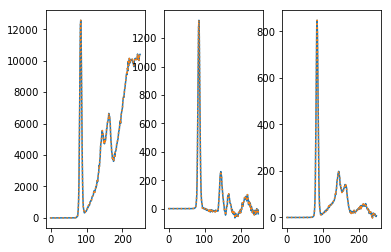

In [267]:
hq3, hQ3, g3 = gG_l_record(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)
plt.subplot(1,3,1)
plt.plot(g)
plt.plot(g3, ls=':')
plt.subplot(1,3,2)
plt.plot(hq, label='hq')
plt.plot(hq3, ls=':', label='hq3')
plt.subplot(1,3,3)
plt.plot(hQ, label='hQ')
plt.plot(hQ3, ls=':', label='hQ3')

In [268]:
%timeit gG_l_record(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 1.14 s per loop


In [212]:
%debug

> <ipython-input-210-923716ae9c93>(27)gG_l_record()
     26     query = centertree.sparse_distance_matrix(tree, maxdist, output_type='ndarray')
---> 27     query.i = centerindex[query.i]
     28     good = query.j != query.i

ipdb> query.dtype
dtype([('i', '<i8'), ('j', '<i8'), ('v', '<f8')], align=True)
ipdb> query['i'].shape
(962782,)
ipdb> q


In [51]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

from scipy.spatial import cKDTree as KDTree
#from scipy.spatial cimport cKDTree as KDTree
from colloids import particles, boo
from colloids.boo import boo_product

#_dtype = [('i',np.intp),('j',np.intp),('v',np.float64)]
#res_dtype = np.dtype(_dtype, align = True)
cdef packed struct ijdist:
    np.intp_t i,j
    np.float64_t v

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_gG_l(
    np.ndarray[np.float64_t, ndim=2] pos, 
    qlms, Qlms, 
    is_center, 
    int Nbins, float maxdist):
    """Spatial correlation of the qlms and the Qlms (non normalized.
    For each particle tagged as is_center, do the cross product between their qlm, their Qlm and count, 
    then bin each quantity with respect to distance. 
    The two first sums need to be normalised by the last one.
    
     - pos is a Nxd array of coordinates, with d the dimension of space
     - qlm is a Nx(2l+1) array of boo coordinates for l-fold symmetry
     - Qlm is the coarse-grained version of qlm
     - is_center is a N array of booleans. For example all particles further away than maxdist from any edge of the box.
     - Nbins is the number of bins along r
     - maxdist is the maximum distance considered"""
    cdef int i,it,j,r
    cdef float rsq
    assert len(pos) == len(qlms)
    assert len(qlms) == len(Qlms)
    assert len(is_center) == len(pos)
    #cdef np.ndarray[np.int64_t, ndim=1]  rsq2r = np.sqrt(np.arange(Nbins**2)).astype(int)
    cdef float l2r = (Nbins/maxdist)#**2
    #maxsq = float(maxdist**2)
    hQ = np.zeros(Nbins)
    hq = np.zeros(Nbins)
    g = np.zeros(Nbins, int)
    #spatial indexing
    tree = KDTree(pos, 12)
    centertree = KDTree(pos[is_center], 12)
    centerindex = np.where(is_center)[0]
    cdef np.ndarray[ijdist, ndim=1] query = centertree.sparse_distance_matrix(tree, maxdist, output_type='ndarray')
    for it in range(query.shape[0]):
        i = centerindex[query[it].i]
        if i==query[it].j:
            continue
        r = int(l2r * query[it].v)
        g[r] += 1
    return hq, hQ, g

In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /data/mleocmach/.cache/ipython/cython/_cython_magic_92e8e937093c0f873c54cd3f5518d67b.c:257:
/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:27:0,
                 from /home/mathieu/anaconda3/env

In [52]:
%timeit cython_gG_l(pos, qlm, Qlm, is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 591 ms per loop


Test the final version

In [104]:
reload(boo)

<module 'colloids.boo' from '/data/mleocmach/src/colloids/python/colloids/boo.py'>

In [105]:
hqQ, g = boo.gG_l(pos, [qlm, Qlm], is_center, Nbins=250, maxdist=30.0)

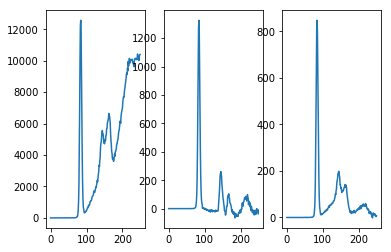

In [106]:
plt.subplot(1,3,1)
plt.plot(g)
plt.subplot(1,3,2)
plt.plot(hqQ[:,0], label='hq')
plt.subplot(1,3,3)
plt.plot(hqQ[:,1], label='hQ')

In [107]:
%timeit boo.gG_l(pos, [qlm, Qlm], is_center, Nbins=250, maxdist=30.0)

1 loops, best of 3: 1.43 s per loop


## Steinhardt gl

In [7]:
maxdist = 30.0
bounds = np.vstack((pos[inside].min(0)+maxdist, pos[inside].max(0)-maxdist))
is_center = (pos>bounds[0]).min(1) & (pos<bounds[1]).min(1)

In [ ]:
hq, g = boo.steinhardt_g_l(pos, bonds, is_center, 250, maxdist)

<weave: compiling>
running build_ext
running build_src
build_src
building extension "sc_9f01faf03310551256b2637495b4f3a20" sources
build_src: building npy-pkg config files
customize UnixCCompiler
customize UnixCCompiler using build_ext
customize UnixCCompiler
customize UnixCCompiler using build_ext
building 'sc_9f01faf03310551256b2637495b4f3a20' extension
compiling C++ sources
C compiler: g++ -pthread -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -fPIC

compile options: '-I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/weave -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/weave/scxx -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/weave/blitz -I/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include -I/home/mathieu/anaconda3/envs/python2/include/python2.7 -c'
extra options: '-O3 -fopenmp'
g++: /data/mleocmach/.cache/scipy/python27_compiled/sc_9f01faf03310551256b2637495b4f3a20.cpp
In file incl